In [2]:
from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker

import pandas as pd
import numpy as np
import itertools
import sys
import re
import os

sys.path.insert(0, "..")

from global_config import config

results_dir   = config.get_property('results_dir')
data_dir      = config.get_property('data_dir')


In [3]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

class ARIMA_model(object):
    @classmethod
    def fit_arima(cls, data, order):
        model = ARIMA(data, order=order).fit()
        aic   = model.aic
        return (model, aic)

    @classmethod
    def optimize_arima(cls, data, d_values=[1]):
        log_data              =  data.copy()
        log_data[log_data==0] += 1

        log_data   = np.log(log_data)
        nlags_use  = np.minimum((len(data) -1)// 2-1, 40)
        acf_d      = acf(log_data.diff().dropna(), nlags=nlags_use, alpha=0.05)
        p_values   = np.where((acf_d[0]<= acf_d[1][:,0]-acf_d[0]) + (acf_d[0]>= acf_d[1][:,1]-acf_d[0]))[0]
        pacf_d     = pacf(log_data.diff().dropna(), nlags=nlags_use, alpha=0.05)
        q_values   = np.where((pacf_d[0]<= pacf_d[1][:,0]-pacf_d[0]) + (pacf_d[0]>= pacf_d[1][:,1]-pacf_d[0]))[0]
        best_aic   = np.inf
        best_model = None
        best_cfg   = None

        for p in tqdm(p_values):
            for d in d_values:
                for q in q_values:
                    order = (p,d,q)
                    try:
                        model, aic = cls.fit_arima(log_data, order=order)
                    except:
                        continue

                    if aic < best_aic:
                        best_aic, best_cfg = aic, order
                        best_model = model

        return (best_model, best_cfg, best_aic)

    def forecast_arima(cls, data=None, T_future=28, quantiles=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 97.5]):
        if data is not None:

            (best_model, best_cfg, best_aic) = cls.optimize_arima(data)
            PredictionResultsWrapper         = best_model.get_forecast(steps=T_future, dynamic=True)
            df_result                        = np.exp(PredictionResultsWrapper.conf_int(alpha=1))
            df_result.columns                = ['mean', 'median']
            df_result.index.name             = 'date'

            for quant in quantiles:
                df_ci            = np.exp(PredictionResultsWrapper.conf_int(alpha=1-quant/100))
                df_ci.columns    = [f'low_{quant}', f'up_{quant}']
                df_ci.index.name = 'date'
                df_result        = pd.merge(df_result, df_ci, left_index=True, right_index=True)

        return df_result


In [4]:
from itertools import product
from tqdm import tqdm

usa_df             = pd.read_csv(os.path.join(data_dir, "processed_data_us.csv"), parse_dates=["date"])
path_to_save_frcst = os.path.join(results_dir, "forecast", "arima")

dates_forecasts    = usa_df.date[11:].values
date_init          = usa_df.date.iloc[0]
FORECAST_MONTHS    = 6
dates_failed       = []

In [5]:
for idx, date in tqdm(enumerate(dates_forecasts)):

    ts = pd.to_datetime(str(date))
    d = ts.strftime('%Y-%m-%d')

    if os.path.isfile(os.path.join(path_to_save_frcst, f"{d}.csv")):
        continue

    print("running for date {}".format(date))

    dates_use       = pd.date_range(start=date_init, end=date, freq="M")
    fit_data        = usa_df[usa_df.date.isin((list(dates_use)))].set_index("date")

    arima_model     =  ARIMA_model()
    forecast_df     = arima_model.forecast_arima(data=fit_data["total"], T_future=(4*FORECAST_MONTHS))
    forecast_df["forecast_date"] = date
    forecast_df["add"]           = 0
    forecast_df.to_csv(os.path.join(path_to_save_frcst, f"{d}.csv"))



191it [00:00, 2181.75it/s]


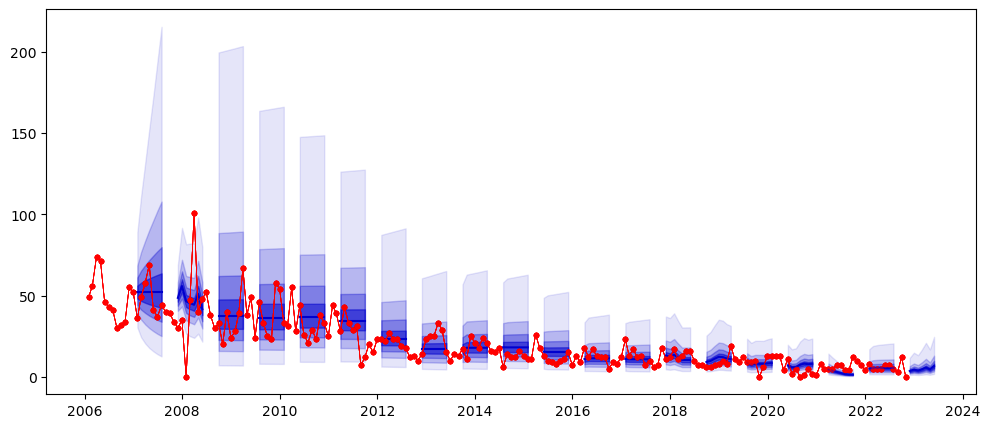

In [6]:
viz_dates = dates_forecasts[::10]

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
for date_plot in viz_dates:
    ds =  pd.to_datetime(date_plot).strftime('%Y-%m-%d')

    forecast_df = pd.read_csv(os.path.join(path_to_save_frcst, f"{ds}.csv"), parse_dates=["date"]).iloc[:7]

    ax.plot(usa_df.date, usa_df["total"], label="IMD", color="red", marker=".", alpha=0.3, lw=0.5)
    ax.plot(forecast_df.date, forecast_df["median"], label=f"{date_plot}", color="mediumblue")

    ax.fill_between(forecast_df.date, forecast_df["up_97.5"], forecast_df["low_97.5"], alpha=0.1, color="mediumblue")
    ax.fill_between(forecast_df.date, forecast_df["up_75"], forecast_df["low_75"], alpha=0.2, color="mediumblue")
    ax.fill_between(forecast_df.date, forecast_df["up_50"], forecast_df["low_50"], alpha=0.3, color="mediumblue")
    ax.fill_between(forecast_df.date, forecast_df["up_25"], forecast_df["low_25"], alpha=0.5, color="mediumblue")